In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models,transforms
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5,0.5,0.5])
std = np.array([0.25,0.25,0.25])

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [4]:
data_dir = 'data/hymenoptera_data/'

In [5]:
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}

In [6]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
            )}

In [7]:
class_names= image_datasets['train'].classes

In [8]:
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=0) for x in ['train','val']} 

In [9]:
dataset_size = {x:len(image_datasets[x]) for x in ['train','val']}

In [10]:
dataset_size

{'train': 244, 'val': 153}

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
def imshow(inp,title):
    inp = inp.numpy().transpose((1,2,0))
    inp = std*inp+mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [13]:
inputs,classes = next(iter(dataloaders['train']))

In [14]:
inputs

tensor([[[[-1.1373, -0.5725, -0.2275,  ...,  0.9804,  0.8549,  0.5255],
          [-1.1059, -0.5412, -0.1961,  ...,  1.1216,  0.8863,  0.5882],
          [-0.8863, -0.3529, -0.0863,  ...,  1.1059,  0.9333,  0.7294],
          ...,
          [ 0.9647,  1.1529,  1.1059,  ..., -0.8549, -0.9020, -0.9961],
          [ 1.1216,  1.4353,  0.9490,  ..., -0.8392, -1.0118, -1.1216],
          [ 1.6235,  1.2471,  0.5255,  ..., -0.9333, -1.0745, -1.2000]],

         [[-1.0275, -0.4471, -0.1020,  ...,  1.1059,  0.9490,  0.5882],
          [-0.9647, -0.3686, -0.0235,  ...,  1.2157,  0.9490,  0.6353],
          [-0.7137, -0.1961,  0.0549,  ...,  1.2157,  1.0118,  0.7765],
          ...,
          [ 1.0431,  1.1529,  1.0588,  ..., -0.8706, -0.8549, -0.8863],
          [ 1.2000,  1.4353,  0.9020,  ..., -0.8706, -0.9804, -0.9961],
          [ 1.7020,  1.2471,  0.4941,  ..., -0.9647, -1.0431, -1.0902]],

         [[-0.3373,  0.0706,  0.1647,  ...,  1.2941,  1.0745,  0.7451],
          [-0.2588,  0.1176,  

In [15]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [16]:
classes

tensor([0, 0, 0, 1])

In [17]:
inputs_val,classes_val = next(iter(dataloaders['val']))

In [18]:
inputs_val.shape

torch.Size([4, 3, 224, 224])

In [19]:
out = torchvision.utils.make_grid(inputs)

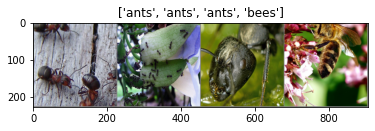

In [20]:
imshow(out,title=[class_names[x] for x in classes])

In [62]:
def train_model(model,criterion,optimizer,schedular,num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forword pass
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    #backwards
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                schedular.step()
                epoch_loss = running_loss/dataset_size[phase]
                epoch_acc = running_corrects.double()/dataset_size[phase]
                print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))
                if phase == 'val' and epoch_acc> best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time()-since
    print('Training complet in {:.0f}.{:.0f}s'.format(time_elapsed//60,time_elapsed % 60))
    print('Best val Acc:{:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [63]:
model = models.resnet18(pretrained=True)

In [64]:
num_ftrs = model.fc.in_features

In [65]:
model.fc = nn.Linear(num_ftrs,2)

In [66]:
model = model.to(device)

In [67]:
criterion = nn.CrossEntropyLoss()

In [68]:
optimizer = optim.SGD(model.parameters(),lr=0.001)

In [69]:
from torch.optim import lr_scheduler

In [70]:
step_lr_schedular = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [71]:
model = train_model(model,criterion,optimizer,step_lr_schedular,num_epochs=25)

Epoch 0/24
----------
train Loss:0.6300 Acc:0.6516

Epoch 1/24
----------
train Loss:0.5123 Acc:0.7295

Epoch 2/24
----------
train Loss:0.4450 Acc:0.7787

Epoch 3/24
----------
train Loss:0.4302 Acc:0.8156

Epoch 4/24
----------
train Loss:0.4248 Acc:0.7992

Epoch 5/24
----------
train Loss:0.3578 Acc:0.8279

Epoch 6/24
----------
train Loss:0.4201 Acc:0.8033

Epoch 7/24
----------
train Loss:0.4276 Acc:0.7951

Epoch 8/24
----------
train Loss:0.3794 Acc:0.8361

Epoch 9/24
----------
train Loss:0.3703 Acc:0.8443

Epoch 10/24
----------
train Loss:0.3552 Acc:0.8689

Epoch 11/24
----------
train Loss:0.3804 Acc:0.8361

Epoch 12/24
----------
train Loss:0.3944 Acc:0.8115

Epoch 13/24
----------
train Loss:0.3727 Acc:0.8320

Epoch 14/24
----------
train Loss:0.3189 Acc:0.8689

Epoch 15/24
----------
train Loss:0.3104 Acc:0.8770

Epoch 16/24
----------
train Loss:0.4048 Acc:0.8197

Epoch 17/24
----------
train Loss:0.3818 Acc:0.8402

Epoch 18/24
----------
train Loss:0.3040 Acc:0.8607

Epo

In [72]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss:0.6629 Acc:0.5943

Epoch 1/24
----------
train Loss:0.5017 Acc:0.7541

Epoch 2/24
----------
train Loss:0.4910 Acc:0.7746

Epoch 3/24
----------
train Loss:0.4000 Acc:0.8238

Epoch 4/24
----------
train Loss:0.4582 Acc:0.7705

Epoch 5/24
----------
train Loss:0.4425 Acc:0.7828

Epoch 6/24
----------
train Loss:0.3409 Acc:0.8730

Epoch 7/24
----------
train Loss:0.3025 Acc:0.8770

Epoch 8/24
----------
train Loss:0.3279 Acc:0.8566

Epoch 9/24
----------
train Loss:0.4191 Acc:0.8033

Epoch 10/24
----------
train Loss:0.3460 Acc:0.8607

Epoch 11/24
----------
train Loss:0.2858 Acc:0.8811

Epoch 12/24
----------
train Loss:0.3815 Acc:0.8115

Epoch 13/24
----------
train Loss:0.3917 Acc:0.7992

Epoch 14/24
----------
train Loss:0.3813 Acc:0.8361

Epoch 15/24
----------
train Loss:0.3461 Acc:0.8361

Epoch 16/24
----------
train Loss:0.3177 Acc:0.8566

Epoch 17/24
----------
train Loss:0.3530 Acc:0.8361

Epoch 18/24
----------
train Loss:0.3510 Acc:0.8443

Epo

In [73]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss:0.6362 Acc:0.6680

Epoch 1/24
----------
train Loss:0.4453 Acc:0.7746

Epoch 2/24
----------
train Loss:0.5225 Acc:0.7418

Epoch 3/24
----------
train Loss:0.5672 Acc:0.7623

Epoch 4/24
----------
train Loss:0.5188 Acc:0.7951

Epoch 5/24
----------
train Loss:0.5344 Acc:0.7910

Epoch 6/24
----------
train Loss:0.4904 Acc:0.7869

Epoch 7/24
----------
train Loss:0.3209 Acc:0.8607

Epoch 8/24
----------
train Loss:0.3805 Acc:0.8402

Epoch 9/24
----------
train Loss:0.3940 Acc:0.8525

Epoch 10/24
----------
train Loss:0.3914 Acc:0.8197

Epoch 11/24
----------
train Loss:0.3919 Acc:0.8238

Epoch 12/24
----------
train Loss:0.3874 Acc:0.8238

Epoch 13/24
----------
train Loss:0.4317 Acc:0.7992

Epoch 14/24
----------
train Loss:0.3553 Acc:0.8443

Epoch 15/24
----------
train Loss:0.3008 Acc:0.8648

Epoch 16/24
----------
train Loss:0.3730 Acc:0.8279

Epoch 17/24
----------
train Loss:0.2457 Acc:0.9057

Epoch 18/24
----------
train Loss:0.3508 Acc:0.8238

Epo